In [1]:
import numpy as np
import pandas as pd

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.utils                          import R_lasso

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')


def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, 
                         intercept = 0, title = None):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    
def plot_convergence(objs, methods, nwarm, eps = 1e-8):
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(111)

    objmin  = np.min([np.min(x) for x in objs])

    for obj, method, iteq in zip(objs, methods, nwarm):
        m_obj = obj[iteq:] - objmin
        m_obj = m_obj[m_obj > 0]
        ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
                 marker = 'o', markersize = 1)
    ax1.legend()

    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("log( max(ELBO) - ELBO )")

    plt.show()
    return

def plot_trendfilter_mrashpen(X, y, beta, ytest, bhat,
                              intercept = 0, title = None):
    n = y.shape[0]
    p = X.shape[1]

    ypred = np.dot(X, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(np.arange(n), ytest, edgecolor = 'black', facecolor='white')
    ax1.plot(np.arange(n), ypred)
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("Y")

    ax2.scatter(np.arange(p), beta, edgecolor = 'black', facecolor = 'white')
    ax2.scatter(np.arange(p), bhat, s = 40, color = 'firebrick')
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("b")
    
    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()
    
def linreg_summary_df(sigma2, objs, methods):
    data     = [[strue * strue,  '-', '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.elbo_path[-1], obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'ELBO', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def linreg_summary_df_noelbo(sigma2, objs, methods):
    data     = [[strue * strue, '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

In [28]:
n = 200
p = 2000
p_causal = 10
pve = 0.7
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.95, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)
s2init = np.var(y - np.mean(y))

In [29]:
'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
lasso_b[np.abs(lasso_b) > 0.1]

array([-0.17406226,  0.10989022,  0.44348001, -0.43090039, -0.77897753,
       -0.49690725, -0.11047429,  0.11570547,  0.86930306,  0.43194023,
       -0.21276732, -0.11025782,  0.13631074])

In [30]:
'''
mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = False)
plr_lbfgs.fit(X, y, sk, binit = lasso_b, winit = wk, s2init = None)

'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, wk, binit = lasso_b, s2init = 1, 
               maxiter = 200, qb_maxiter = 100, calculate_elbo = False)

'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = wk, s2init = 0.1)

'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

mr.ash.pen terminated at iteration 170.
mr.ash.pen (EM) terminated at iteration 200.
Mr.ASH terminated at iteration 346.
Mr.ASH terminated at iteration 78.


In [27]:
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = False, maxiter = 2000)
plr_lbfgs.fit(X, y, sk, binit = lasso_b, winit = wk, s2init = None)

mr.ash.pen terminated at iteration 1432.


In [22]:
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
lasso_b[np.abs(lasso_b) > 0.1]

array([ 1.15245504, -1.08242168, -1.10129228, -0.97315299, -0.31125017,
        1.32154164,  0.66813013])

In [26]:
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
lasso_b[np.abs(lasso_b) > 0.1]

array([ 1.16605406, -1.08785068, -1.10841086, -0.98380809, -0.31668207,
        1.33295755,  0.68467808])

In [34]:
X

array([[-0.38853238, -0.50288196, -1.00830022, ..., -0.59494728,
        -0.54175528, -0.29425156],
       [-1.31918202, -0.87651669, -1.07054046, ..., -0.77333766,
        -1.18615393, -1.03979999],
       [-0.26765298,  0.19166393,  0.32734111, ..., -0.04514184,
         0.2906178 ,  0.34788286],
       ...,
       [ 1.68234113,  1.11576679,  1.23810686, ...,  1.15041757,
         1.22059832,  1.45365096],
       [-0.29085115, -0.21017167, -1.05586844, ..., -0.5346866 ,
        -0.28485622, -0.5837538 ],
       [-0.31292021, -0.30738702, -0.01764277, ...,  0.14142635,
        -0.40564151, -0.20556024]])

In [50]:
wk_pen, sk_pen = initialize_ash_prior(k, scale = 2, sparsity = 0)

plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = False, maxiter = 2000)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk_pen, s2init = None)

mr.ash.pen terminated at iteration 33.


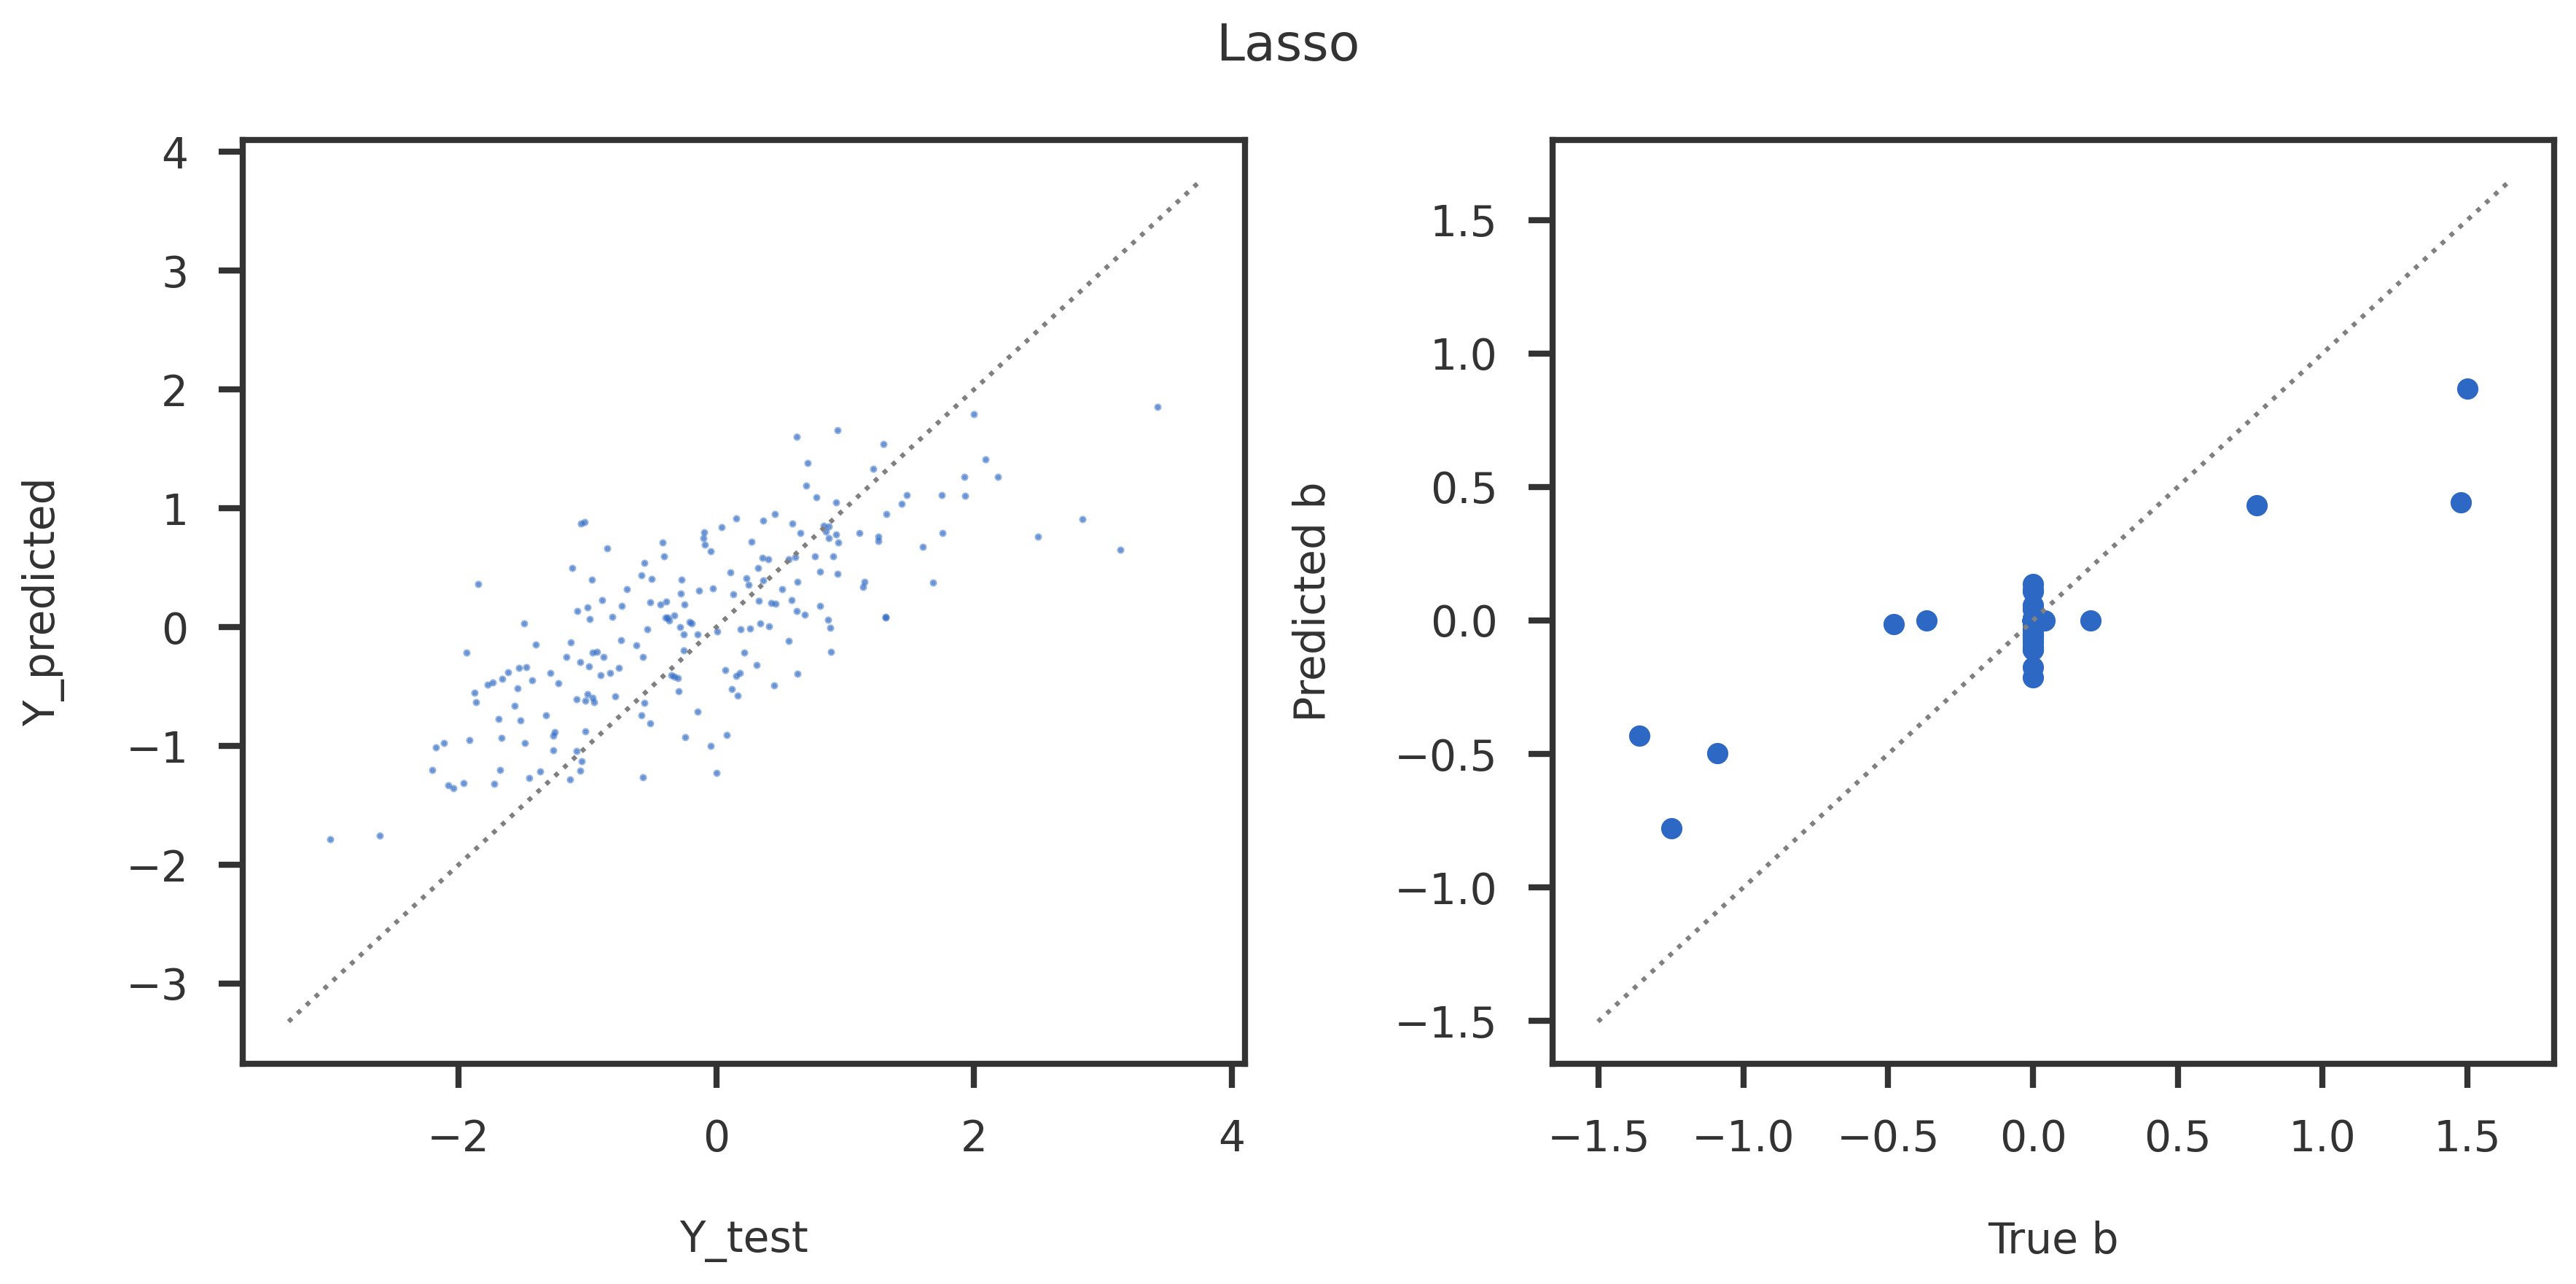

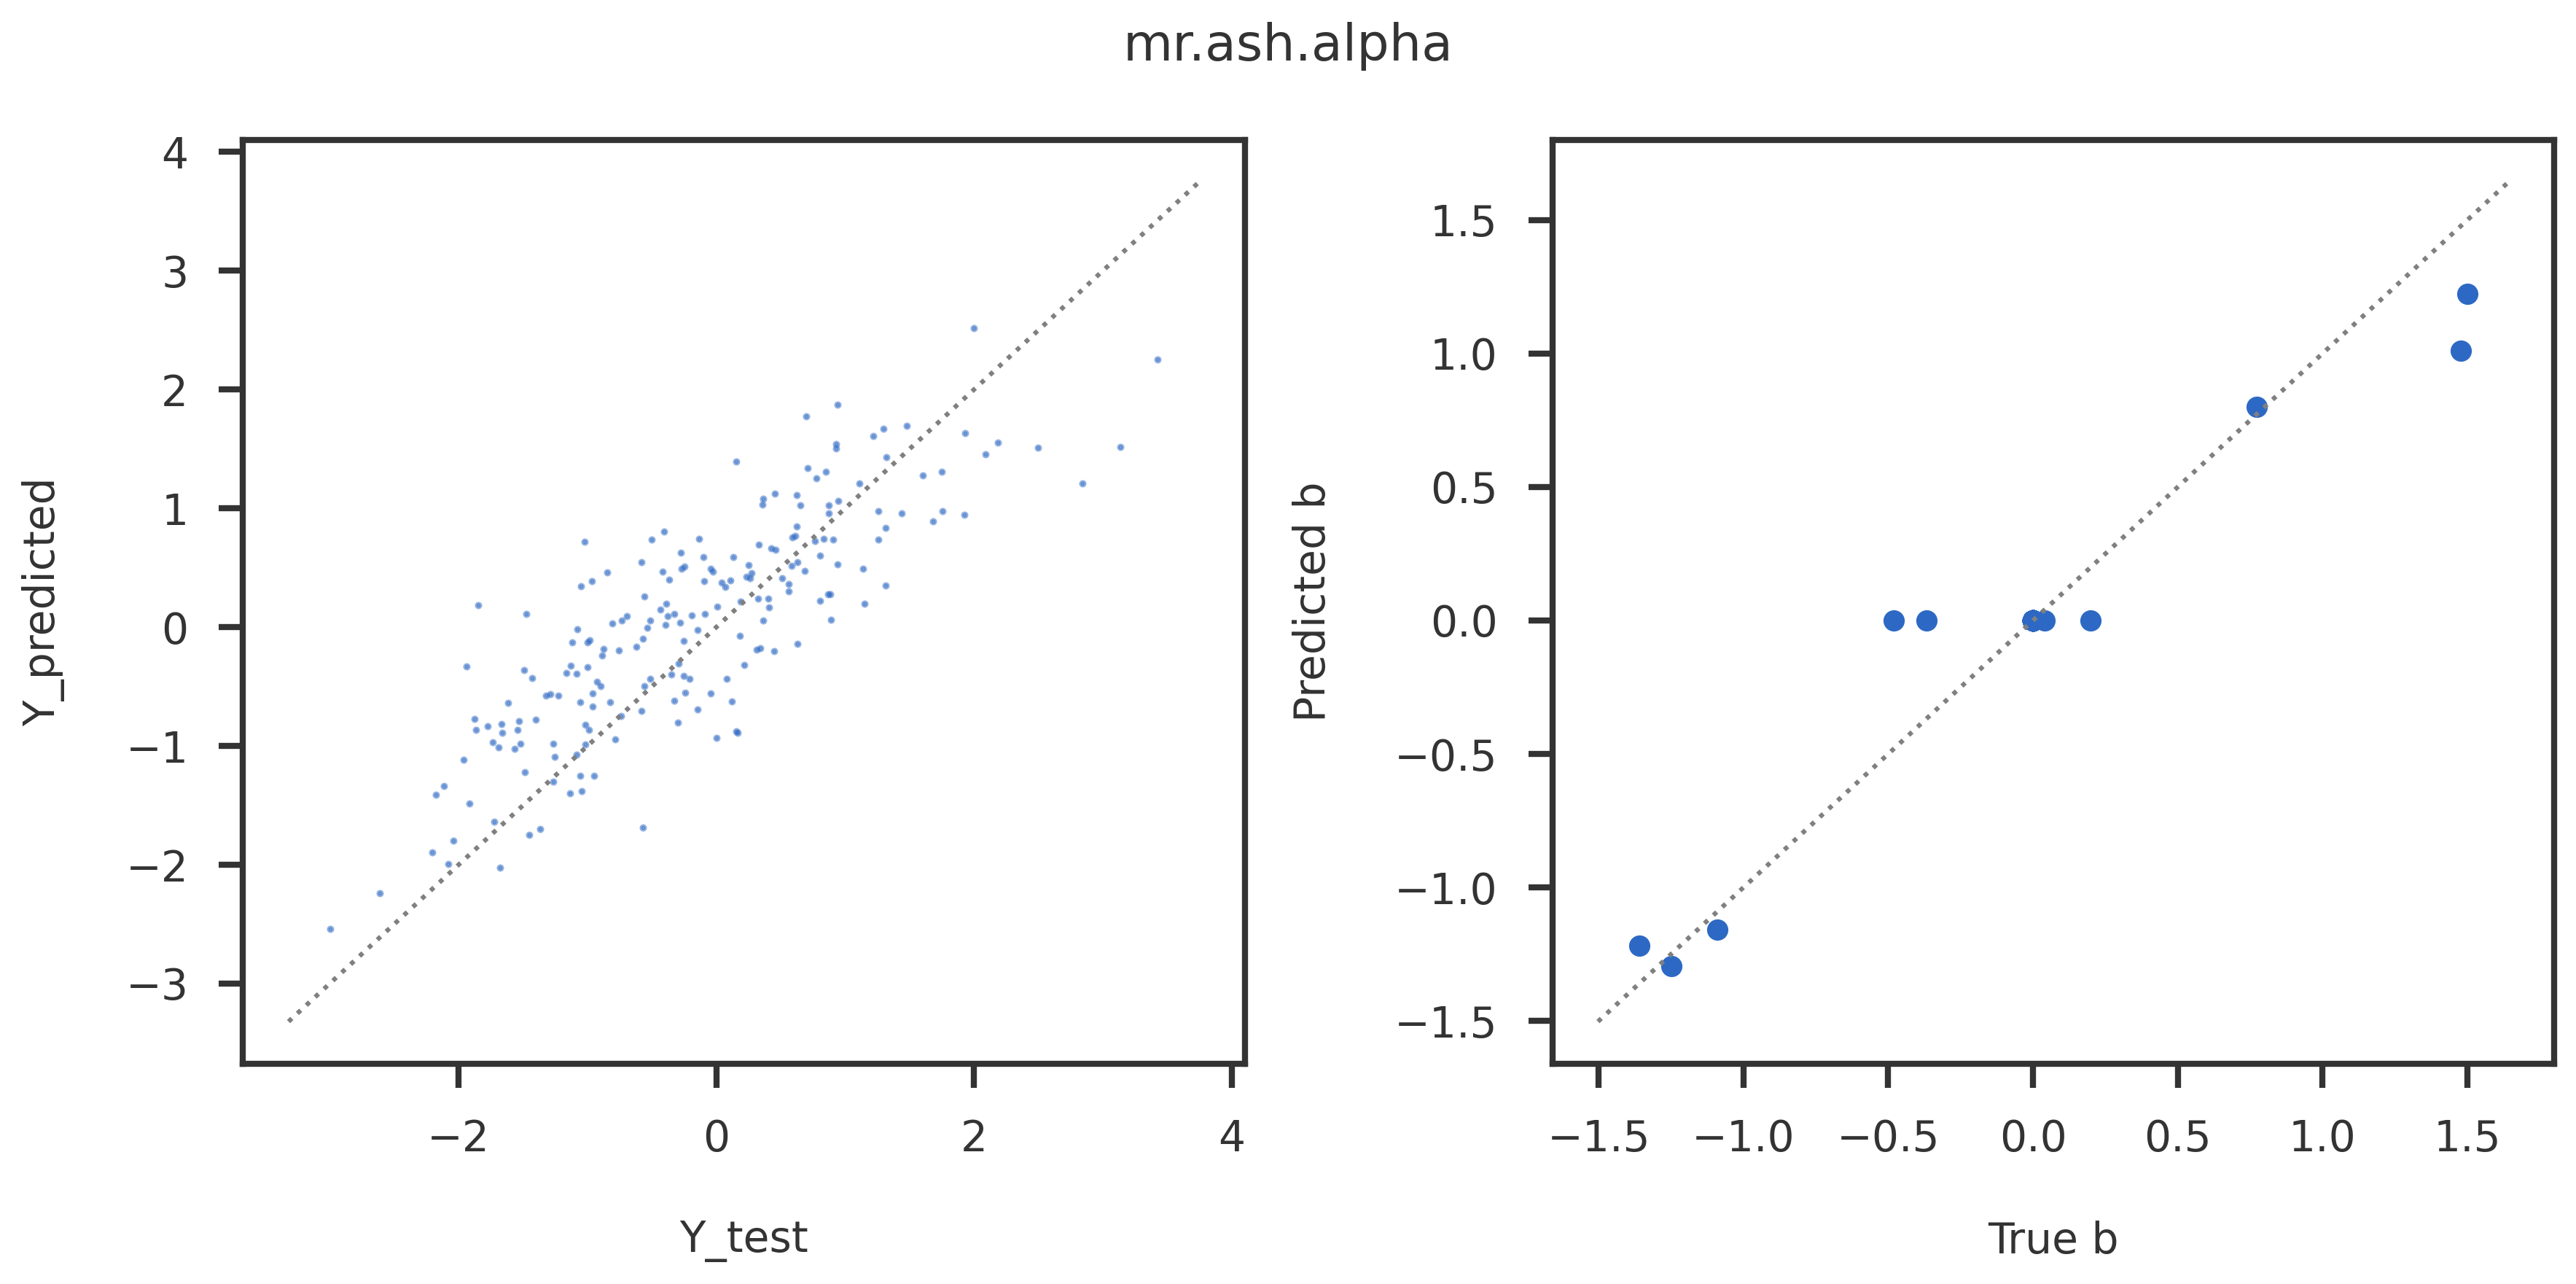

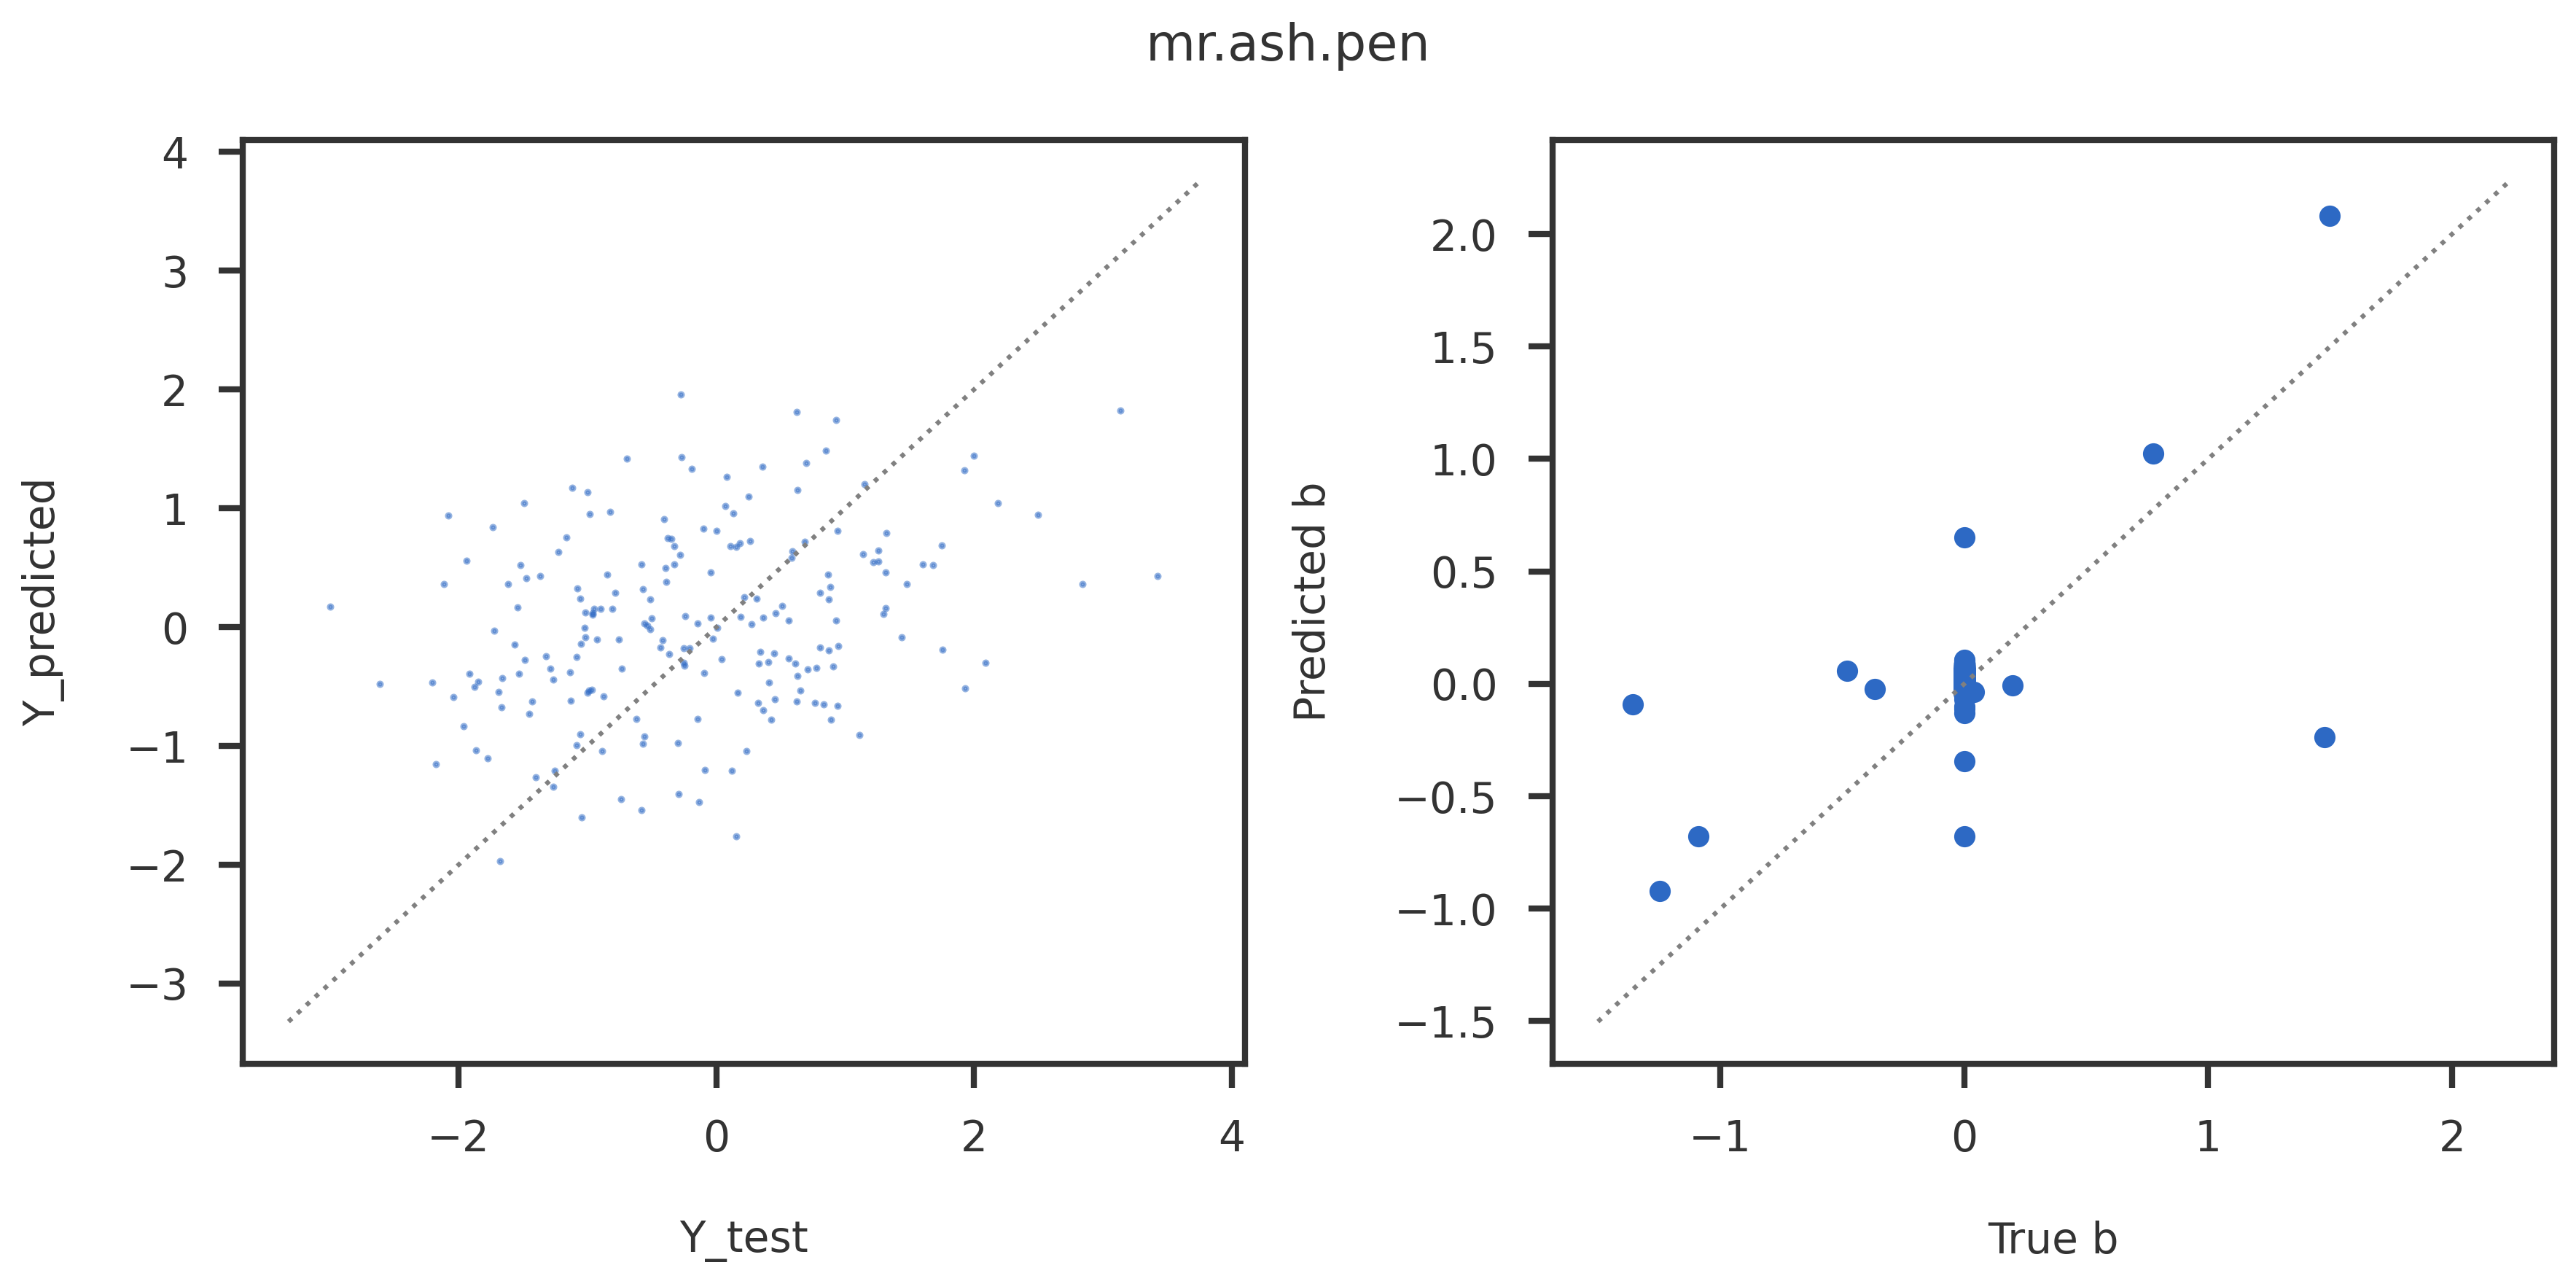

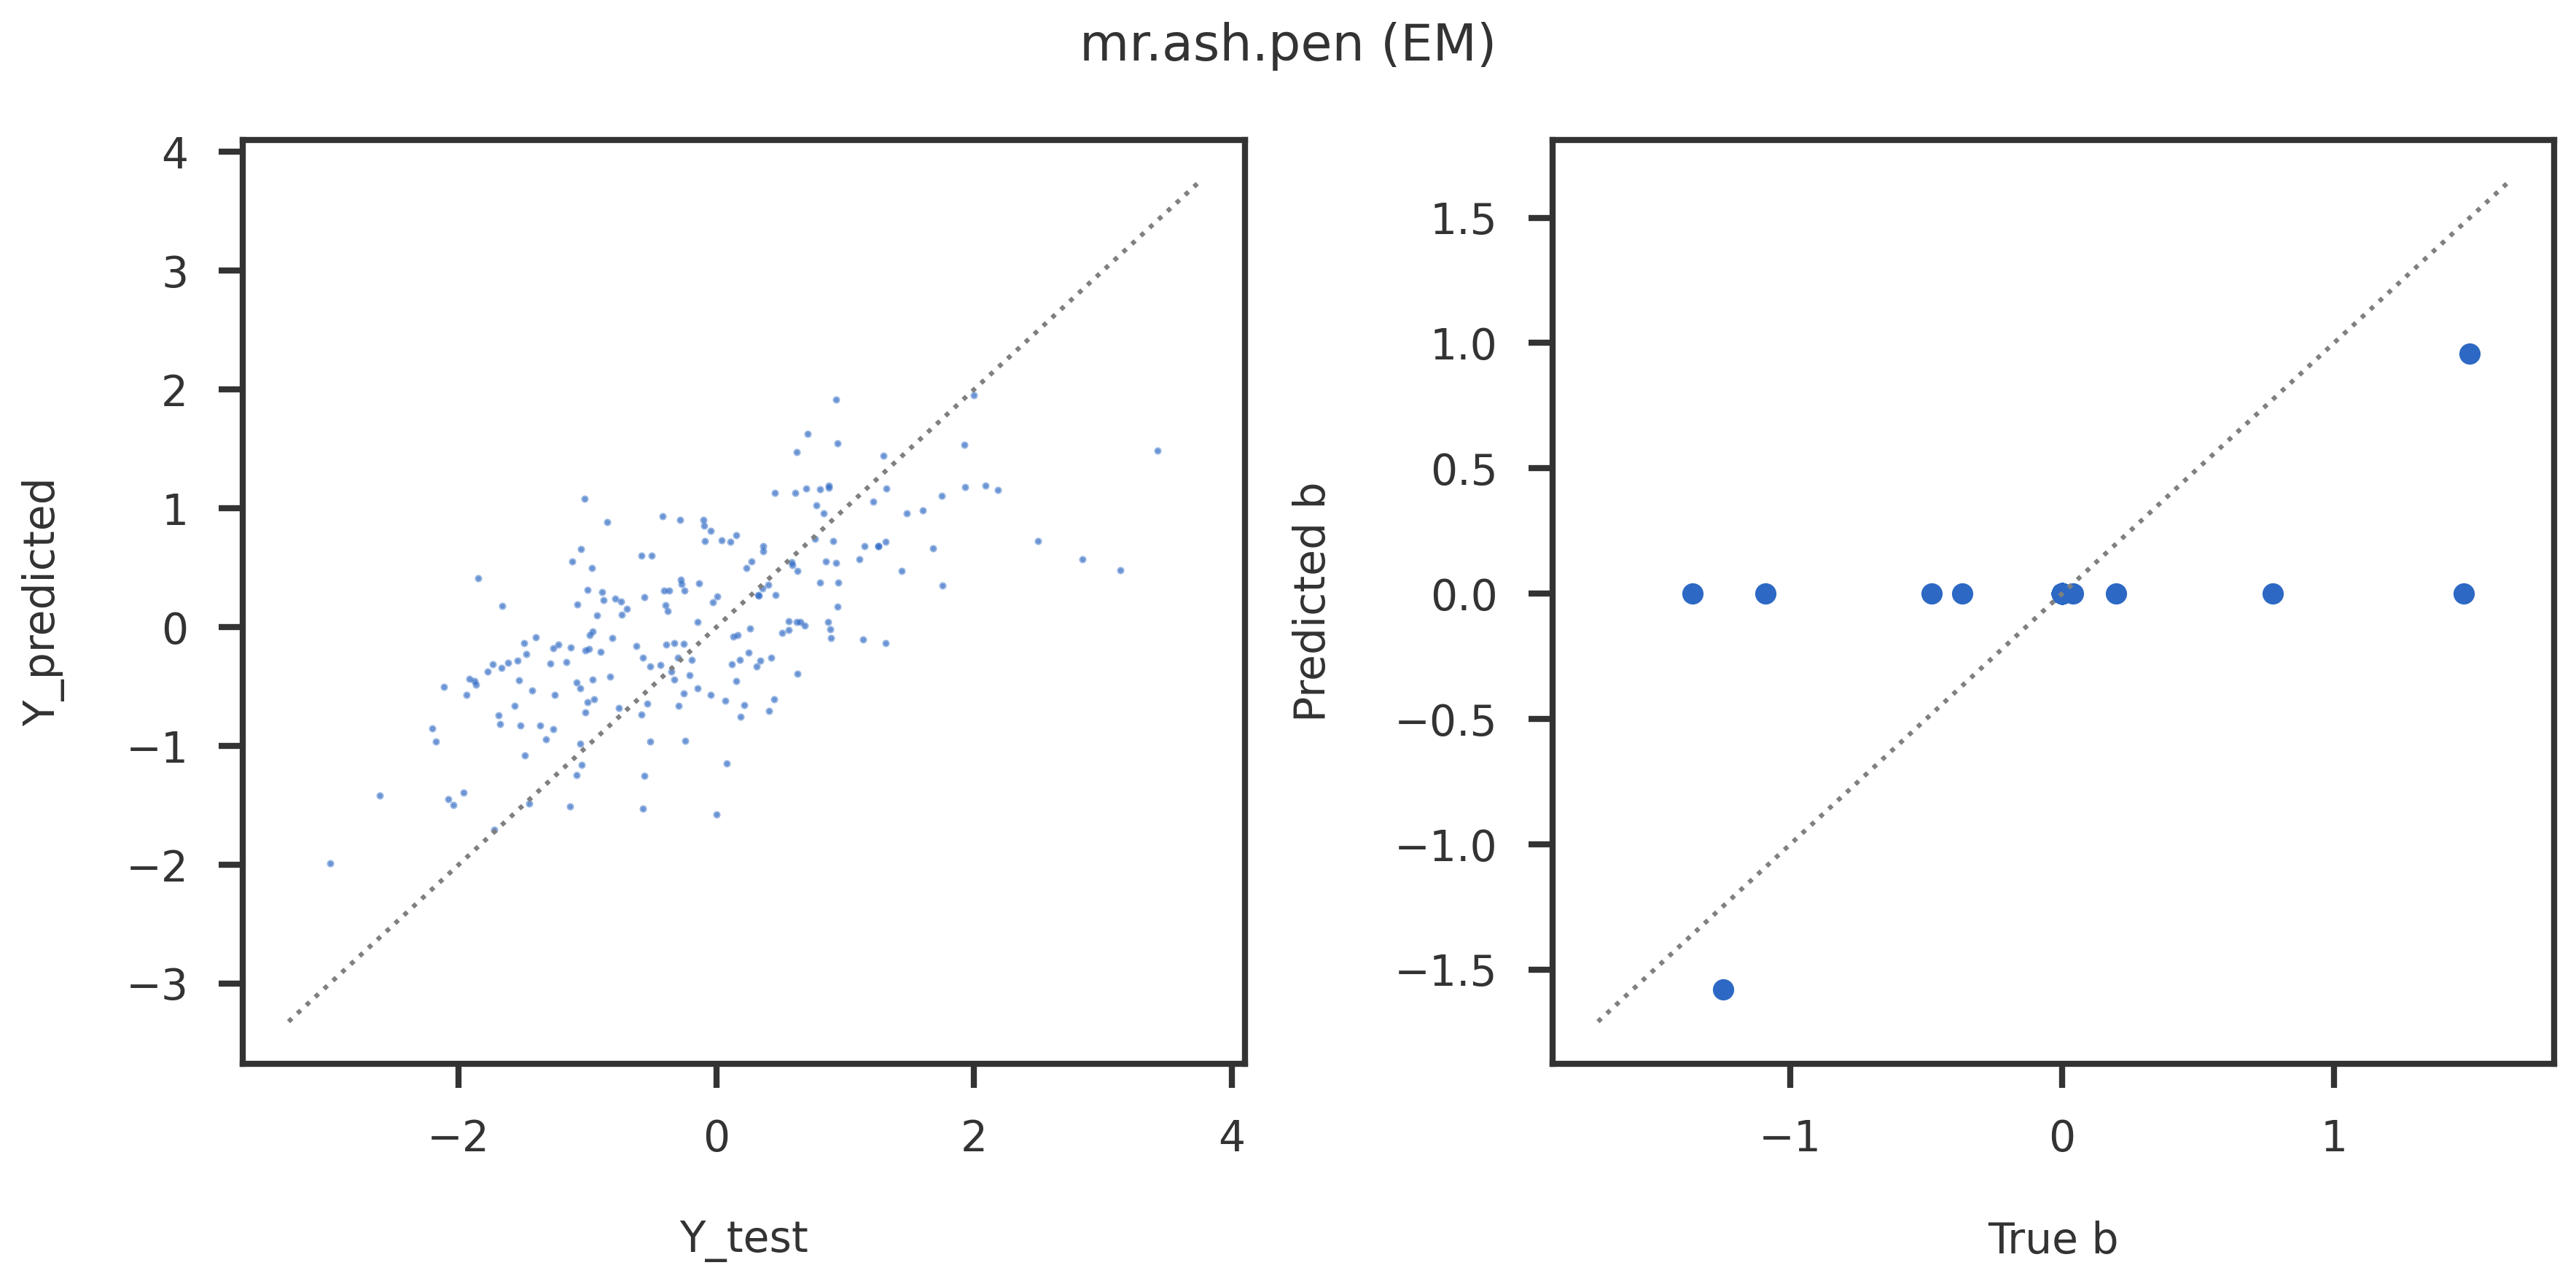

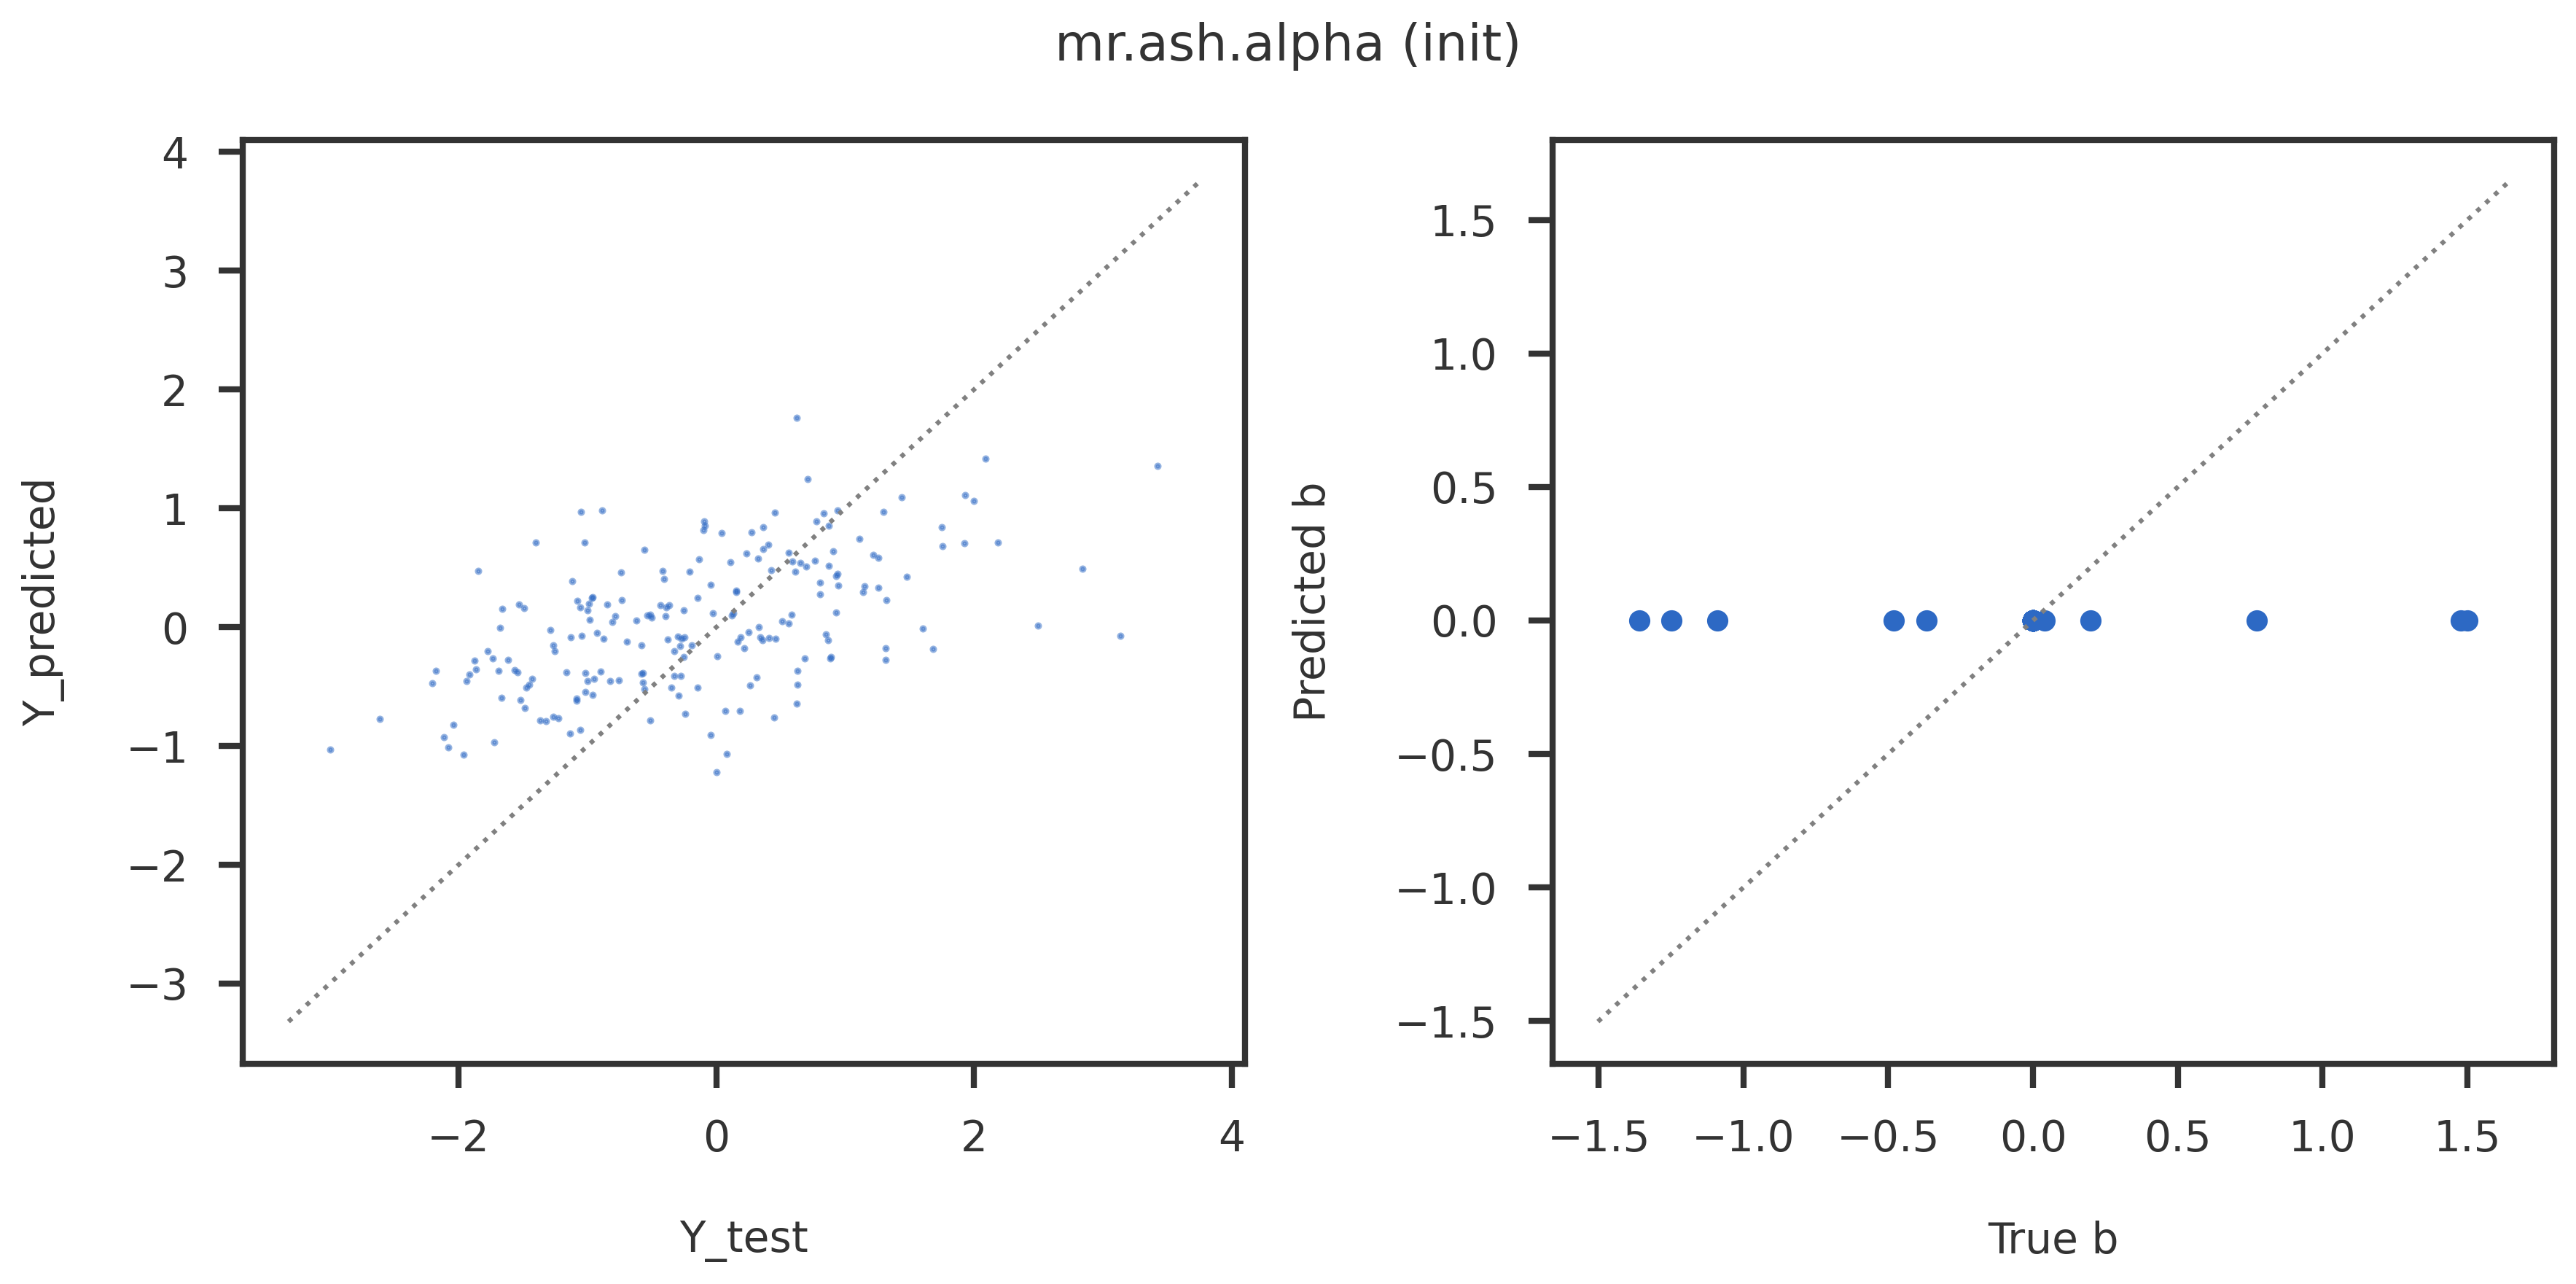

In [51]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     lasso_b, intercept = lasso_a0, title = 'Lasso')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 20, 20, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
#plot_convergence(objs, methods, kinit)

In [49]:
objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df_noelbo(strue, objs, methods)
df

,sigma2,niter
True,0.351862,-
mr.ash.alpha,0.438320,346
mr.ash.pen,0.678928,774
mr.ash.pen (EM),0.631509,802
mr.ash.alpha (init),0.811423,78


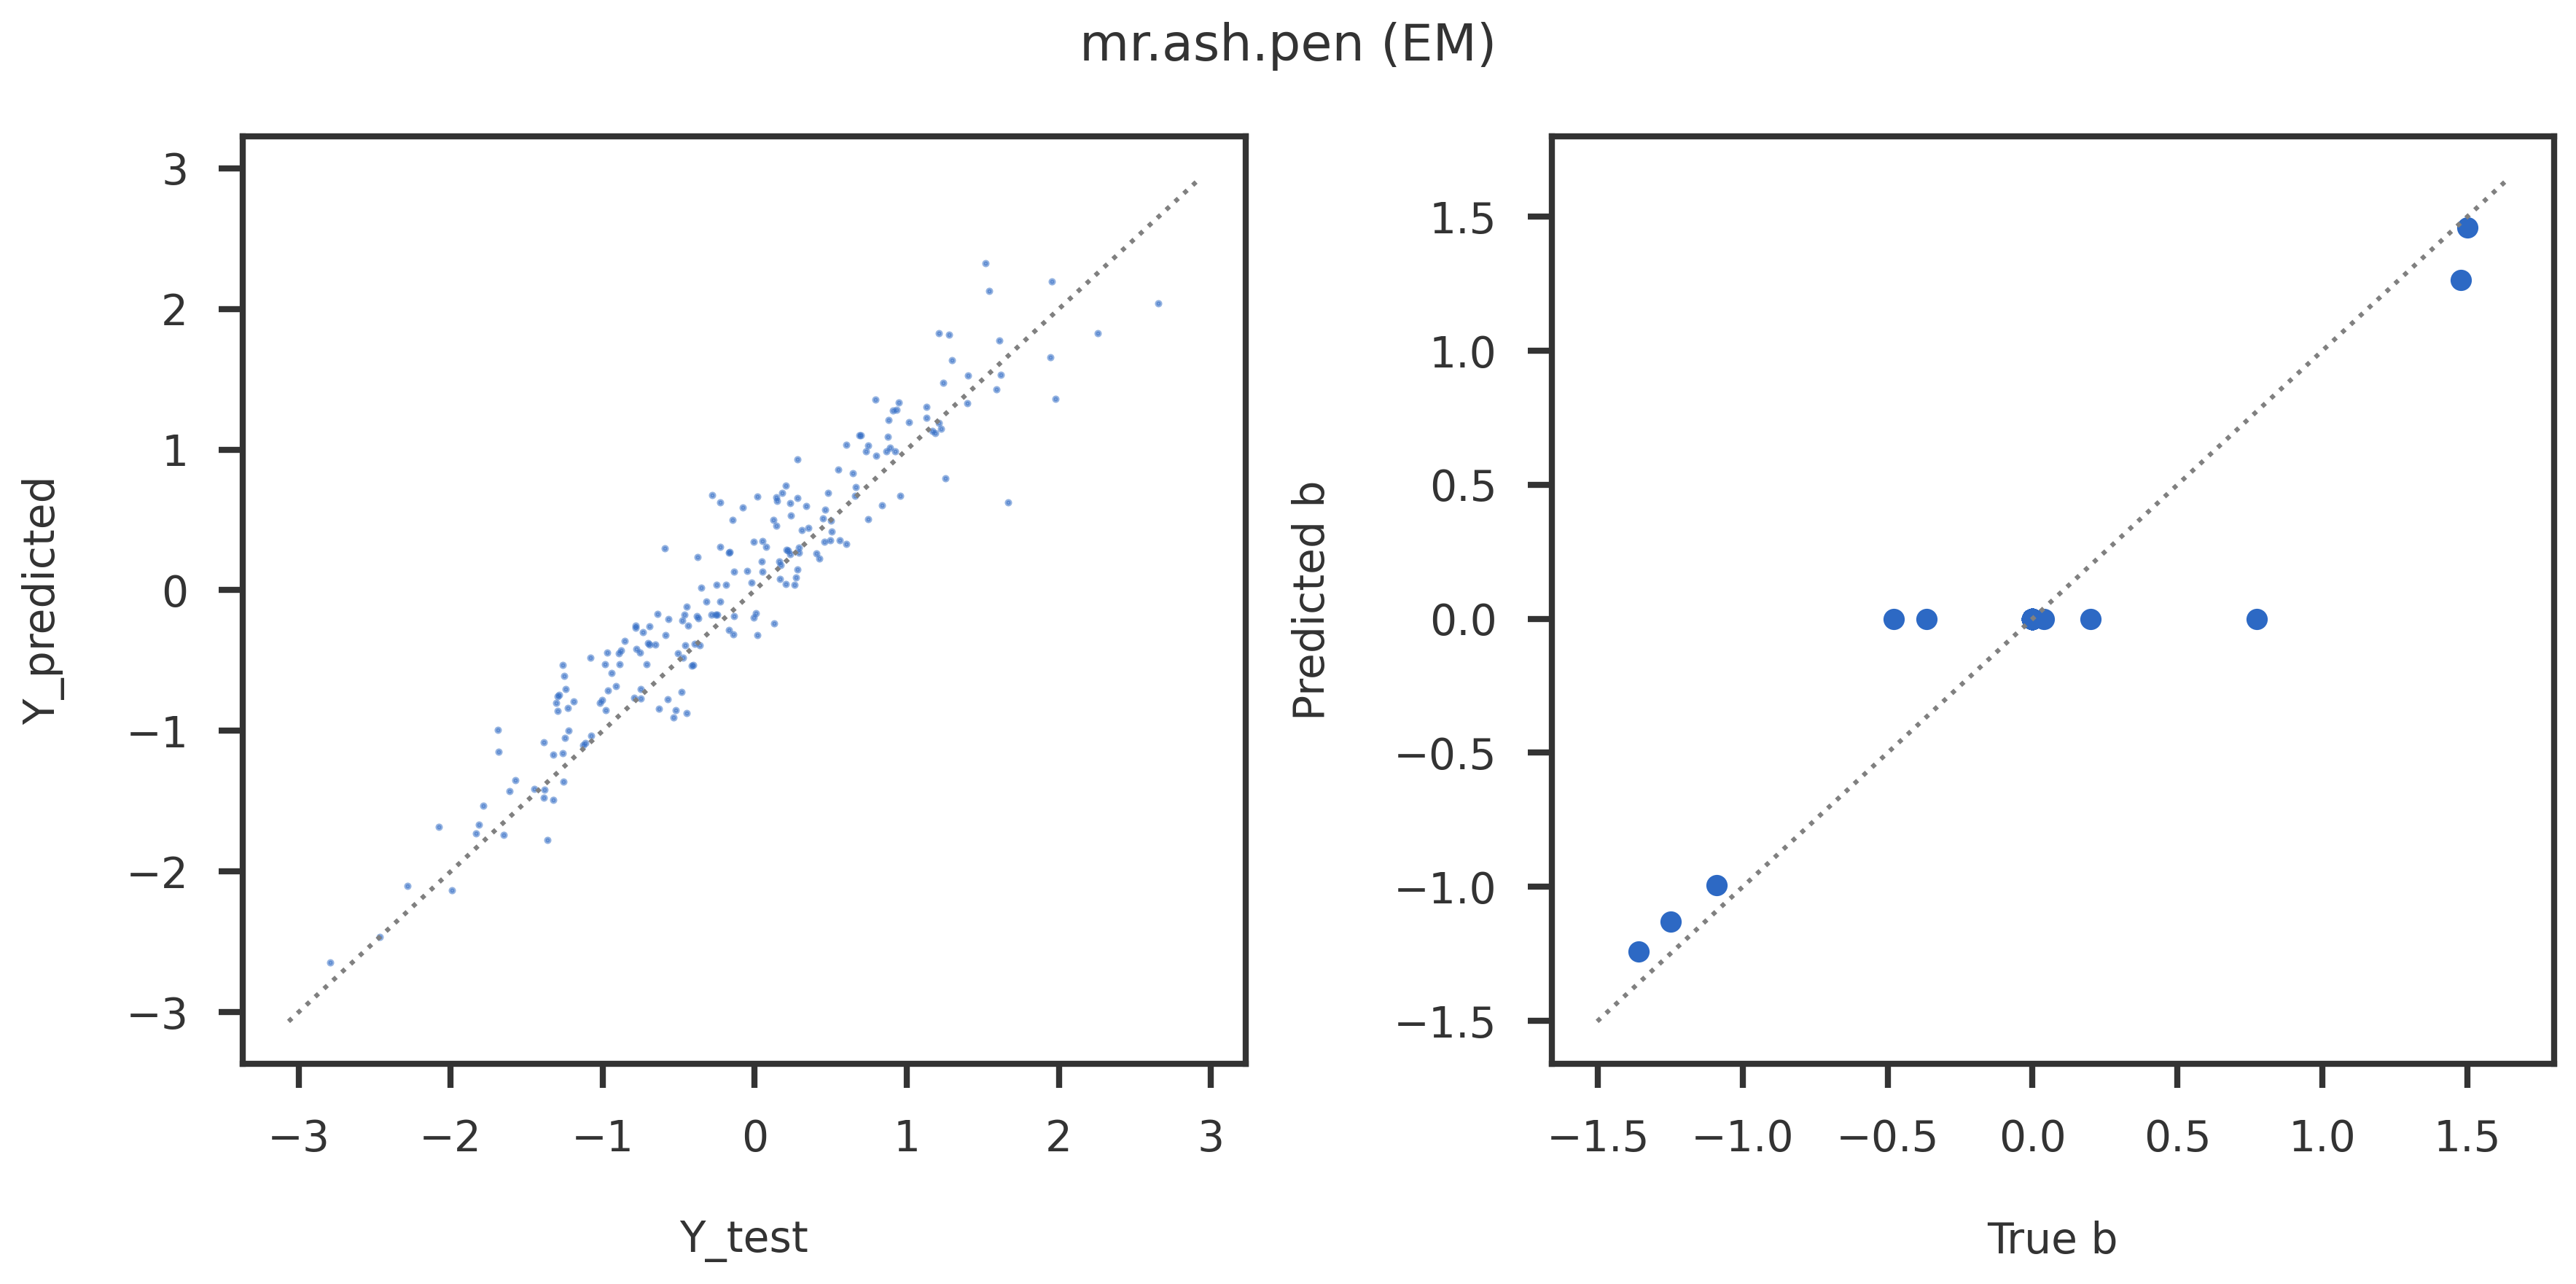

In [7]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')

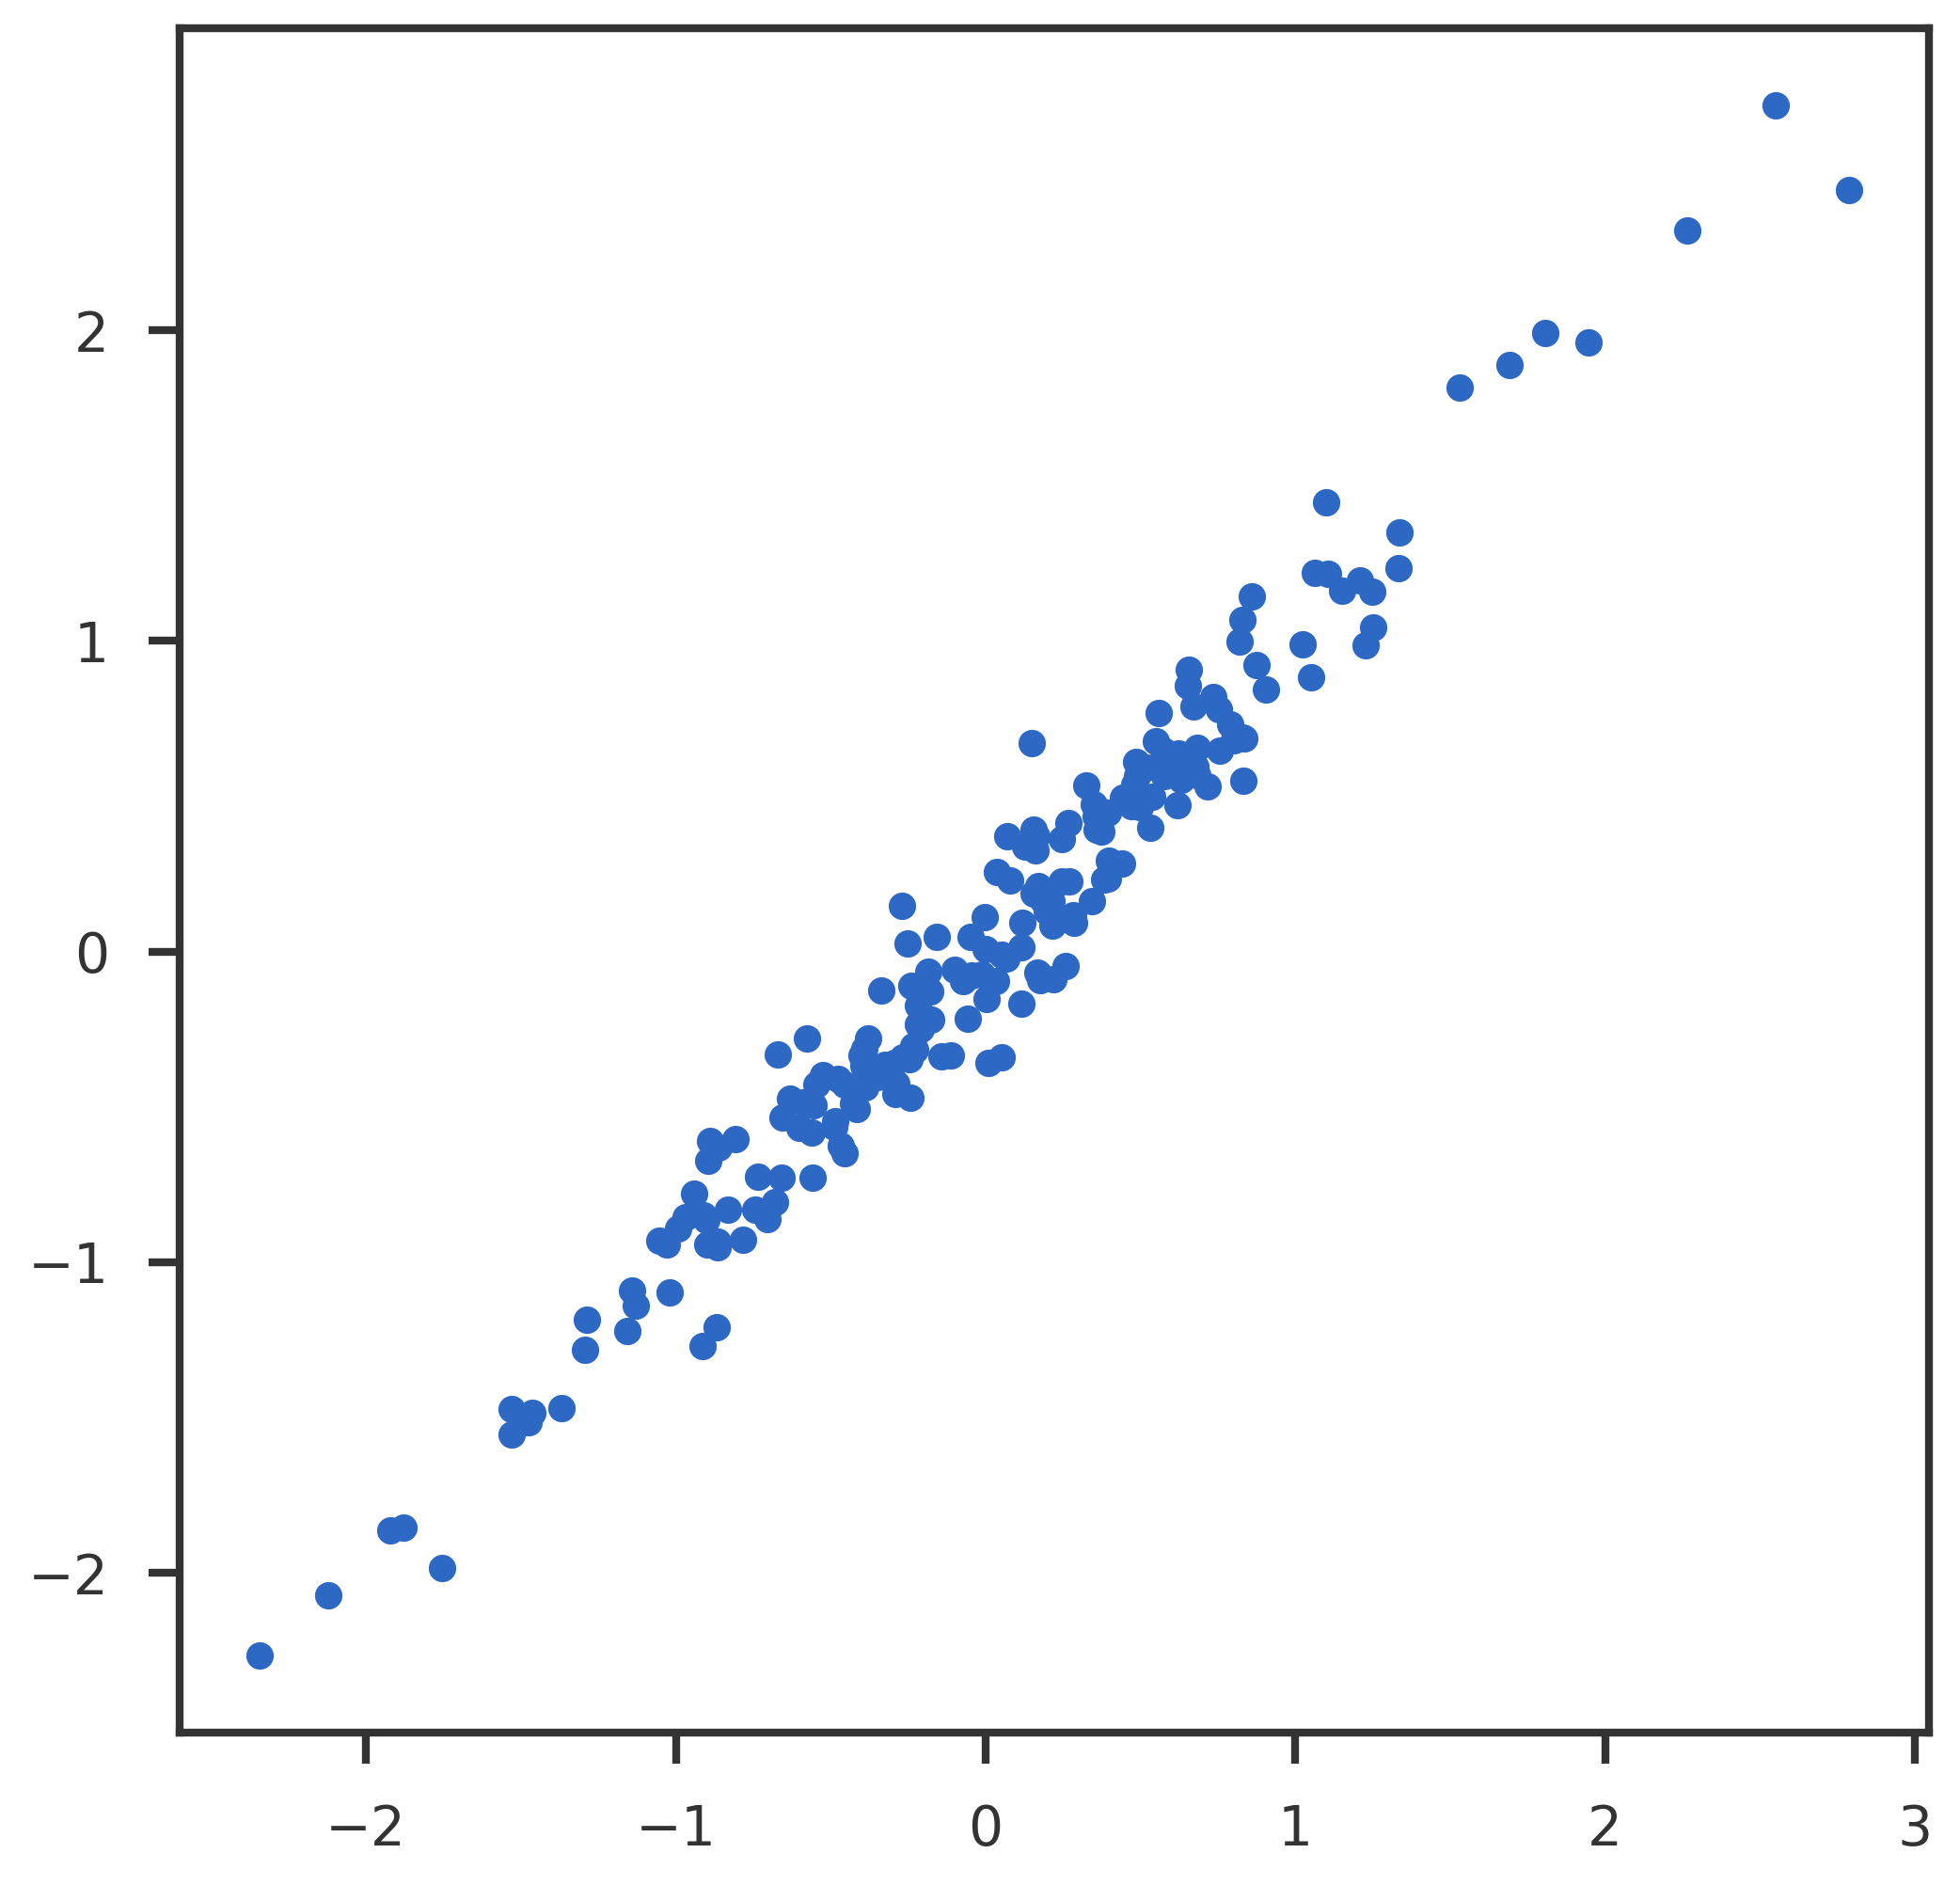

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.dot(X, btrue), np.dot(X, plr_lbfgs.coef))
#ax1.scatter(btrue, plr_eb.coef)
plt.show()

In [9]:
plr_eb.coef[np.abs(btrue) > 0.1]

array([ 1.26315544e+00, -1.24041525e+00, -1.13048718e+00, -9.94767276e-01,
        1.98141217e-06, -1.70920230e-06, -7.24329316e-06,  1.45916717e+00,
        2.21139728e-05])

In [10]:
btrue[np.abs(btrue) > 0.1]

array([ 1.4773462 , -1.35937268, -1.24753798, -1.09007492,  0.19895889,
       -0.36673769, -0.48007765,  1.49958577,  0.77390471])

In [11]:
plr_eb.prior

array([9.97291498e-001, 4.28529655e-010, 9.20119602e-031, 7.04033659e-053,
       5.67422515e-073, 1.24765606e-090, 3.60309537e-106, 5.56453310e-120,
       2.20740016e-132, 1.34892676e-143, 9.31616014e-154, 6.03282989e-163,
       3.32639762e-171, 2.36794986e-178, 3.91614079e-183, 5.32136392e-181,
       1.95392443e-162, 6.76960852e-121, 8.51081197e-064, 2.70850118e-003])

In [12]:
plr_lbfgs.prior

array([6.05288801e-01, 3.91446508e-01, 5.00050551e-12, 5.00050551e-12,
       5.00050551e-12, 5.00050551e-12, 5.00050551e-12, 5.00050551e-12,
       5.00050551e-12, 5.00050551e-12, 5.00050551e-12, 5.00050551e-12,
       5.00050551e-12, 5.00050551e-12, 5.00050551e-12, 5.00050551e-12,
       5.00050551e-12, 5.00050551e-12, 5.00050551e-12, 3.26469079e-03])

In [13]:
mrash_r.prior

array([9.96209482e-01, 8.72566652e-12, 2.40614954e-12, 1.20849161e-12,
       7.66780046e-13, 5.48151633e-13, 4.20485552e-13, 3.37703722e-13,
       2.80097964e-13, 2.38334641e-13, 2.08299987e-13, 1.88682227e-13,
       1.79218040e-13, 1.79923224e-13, 1.91503669e-13, 2.17098513e-13,
       2.69713588e-13, 4.07027288e-13, 9.55838456e-13, 3.79051820e-03])

In [14]:
from mrashpen.inference import coordinate_descent_step as cd_step
cd_step.elbo(X, y, sk, mrash_r.coef, mrash_r.prior, mrash_r.residual_var)

122.03183711269317

In [15]:
from mrashpen.inference import coordinate_descent_step as cd_step
cd_step.elbo(X, y, sk, plr_lbfgs.coef, plr_lbfgs.prior, plr_lbfgs.residual_var)

205.4625831279272

In [16]:
from mrashpen.inference import coordinate_descent_step as cd_step
cd_step.elbo(X, y, sk, mrash_r_init.coef, mrash_r_init.prior, mrash_r_init.residual_var)

125.298171968982

In [17]:
plr_eb.prior

array([9.97291498e-001, 4.28529655e-010, 9.20119602e-031, 7.04033659e-053,
       5.67422515e-073, 1.24765606e-090, 3.60309537e-106, 5.56453310e-120,
       2.20740016e-132, 1.34892676e-143, 9.31616014e-154, 6.03282989e-163,
       3.32639762e-171, 2.36794986e-178, 3.91614079e-183, 5.32136392e-181,
       1.95392443e-162, 6.76960852e-121, 8.51081197e-064, 2.70850118e-003])

In [18]:
plr_lbfgs.prior

array([6.05288801e-01, 3.91446508e-01, 5.00050551e-12, 5.00050551e-12,
       5.00050551e-12, 5.00050551e-12, 5.00050551e-12, 5.00050551e-12,
       5.00050551e-12, 5.00050551e-12, 5.00050551e-12, 5.00050551e-12,
       5.00050551e-12, 5.00050551e-12, 5.00050551e-12, 5.00050551e-12,
       5.00050551e-12, 5.00050551e-12, 5.00050551e-12, 3.26469079e-03])

In [19]:
'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, wk, binit = None, s2init = 1, maxiter = 200, qb_maxiter = 10)

mr.ash.pen (EM) terminated at iteration 3.


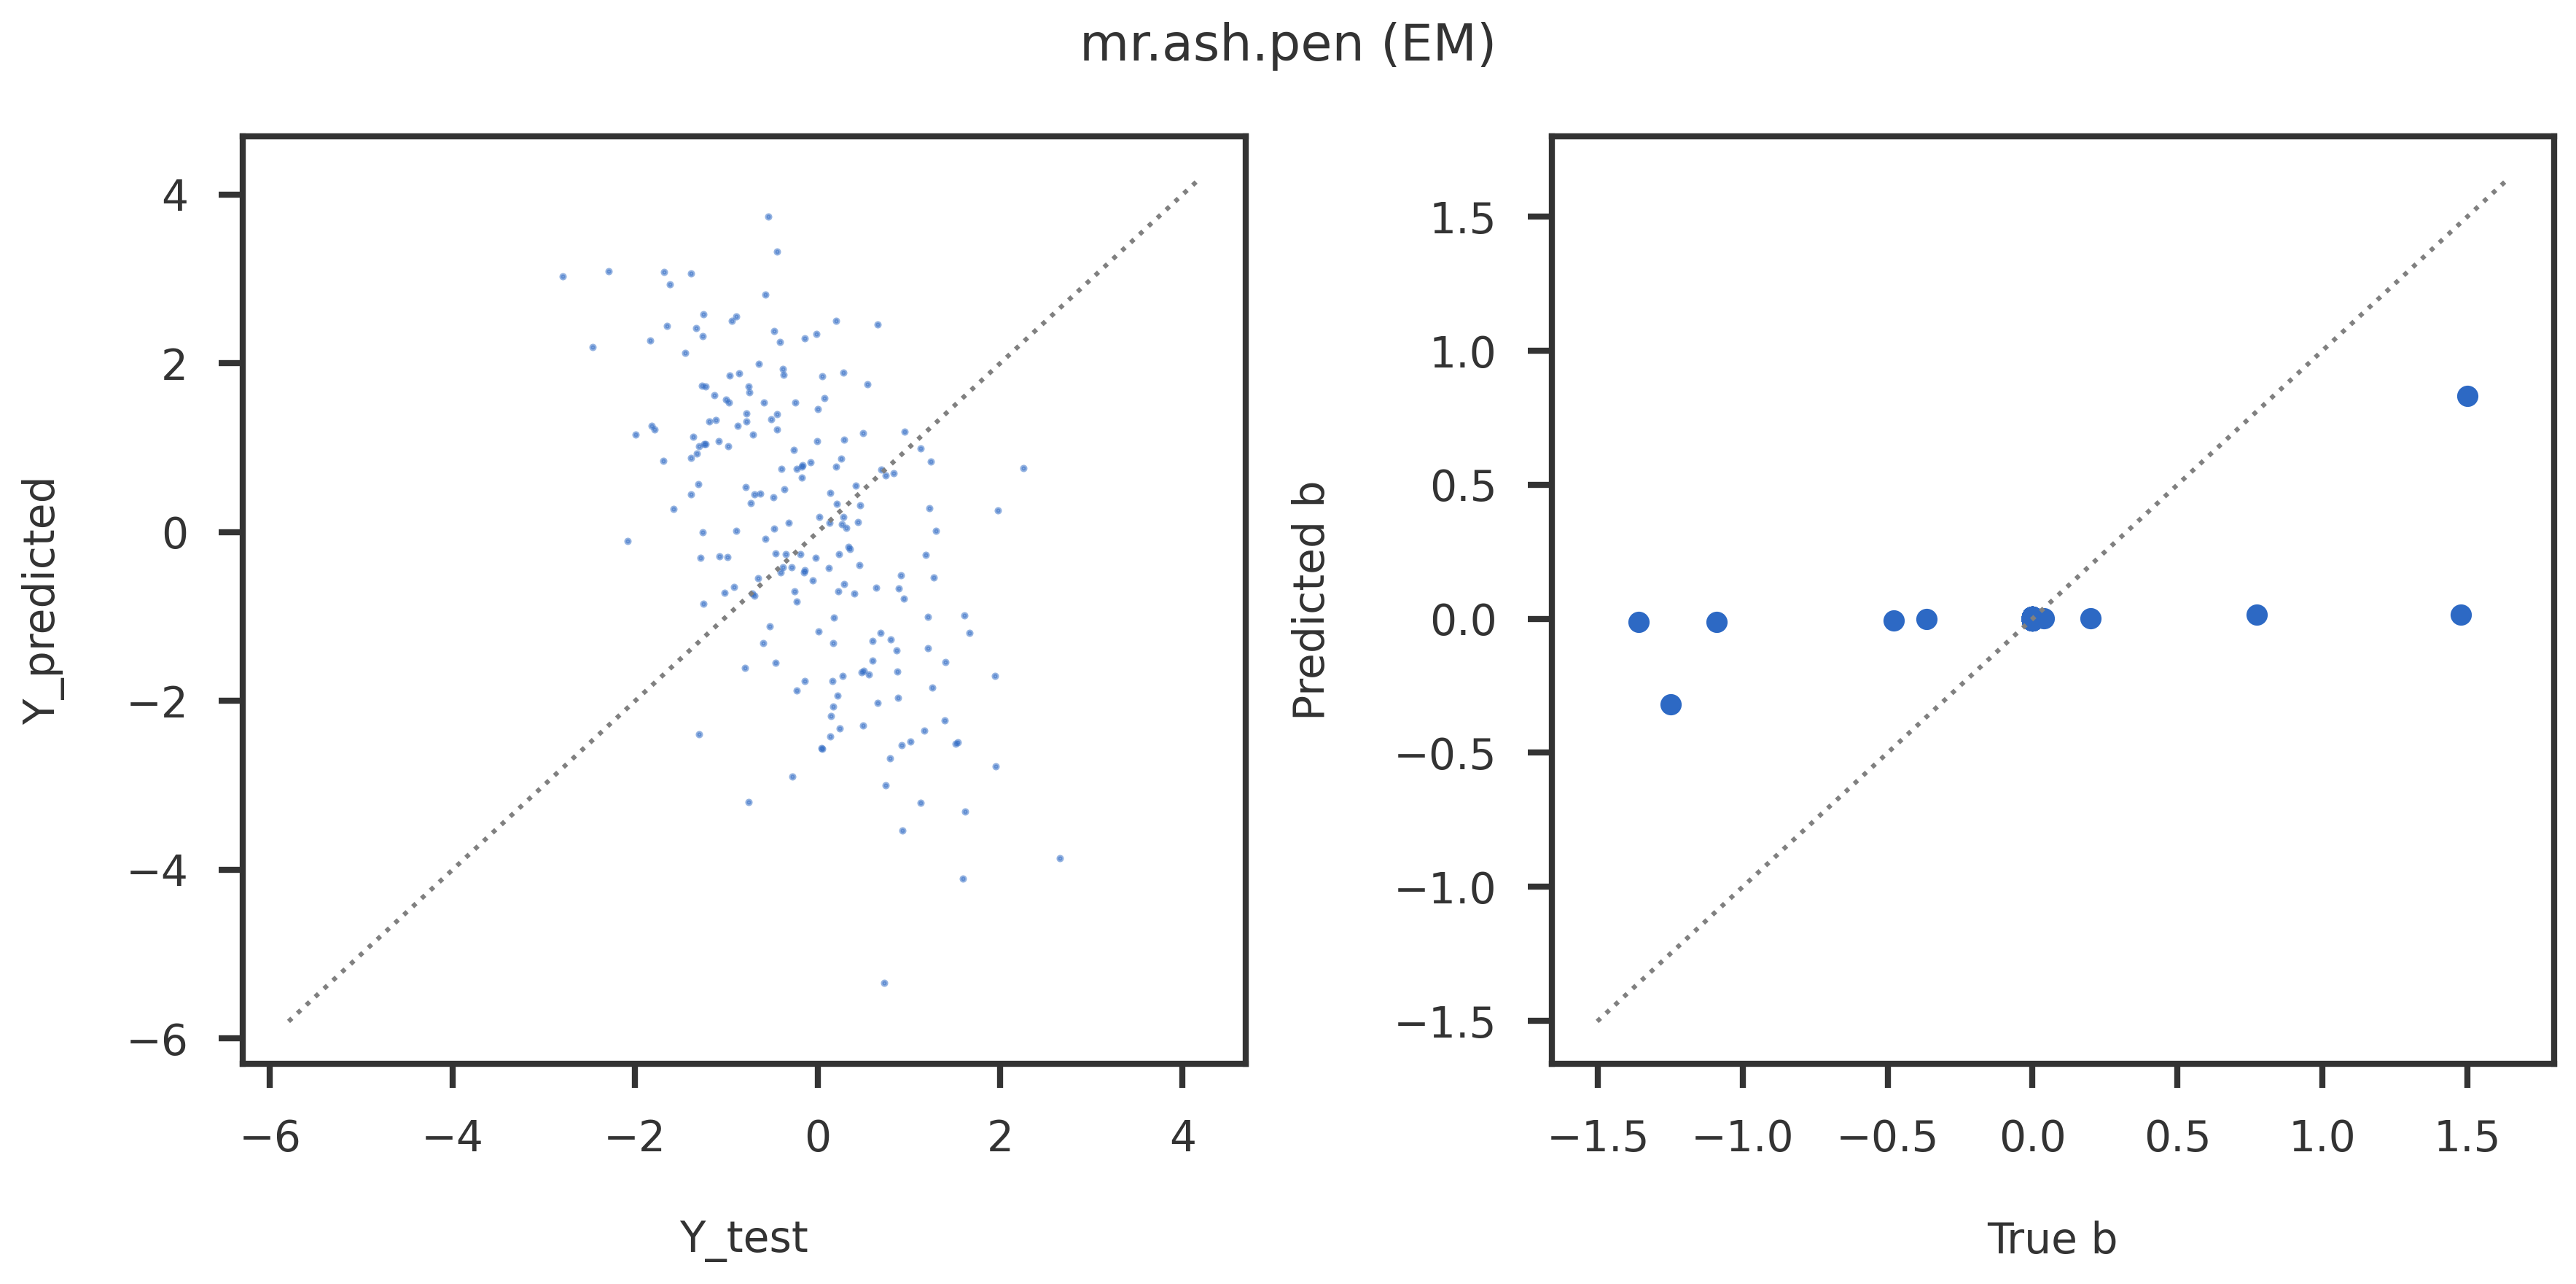

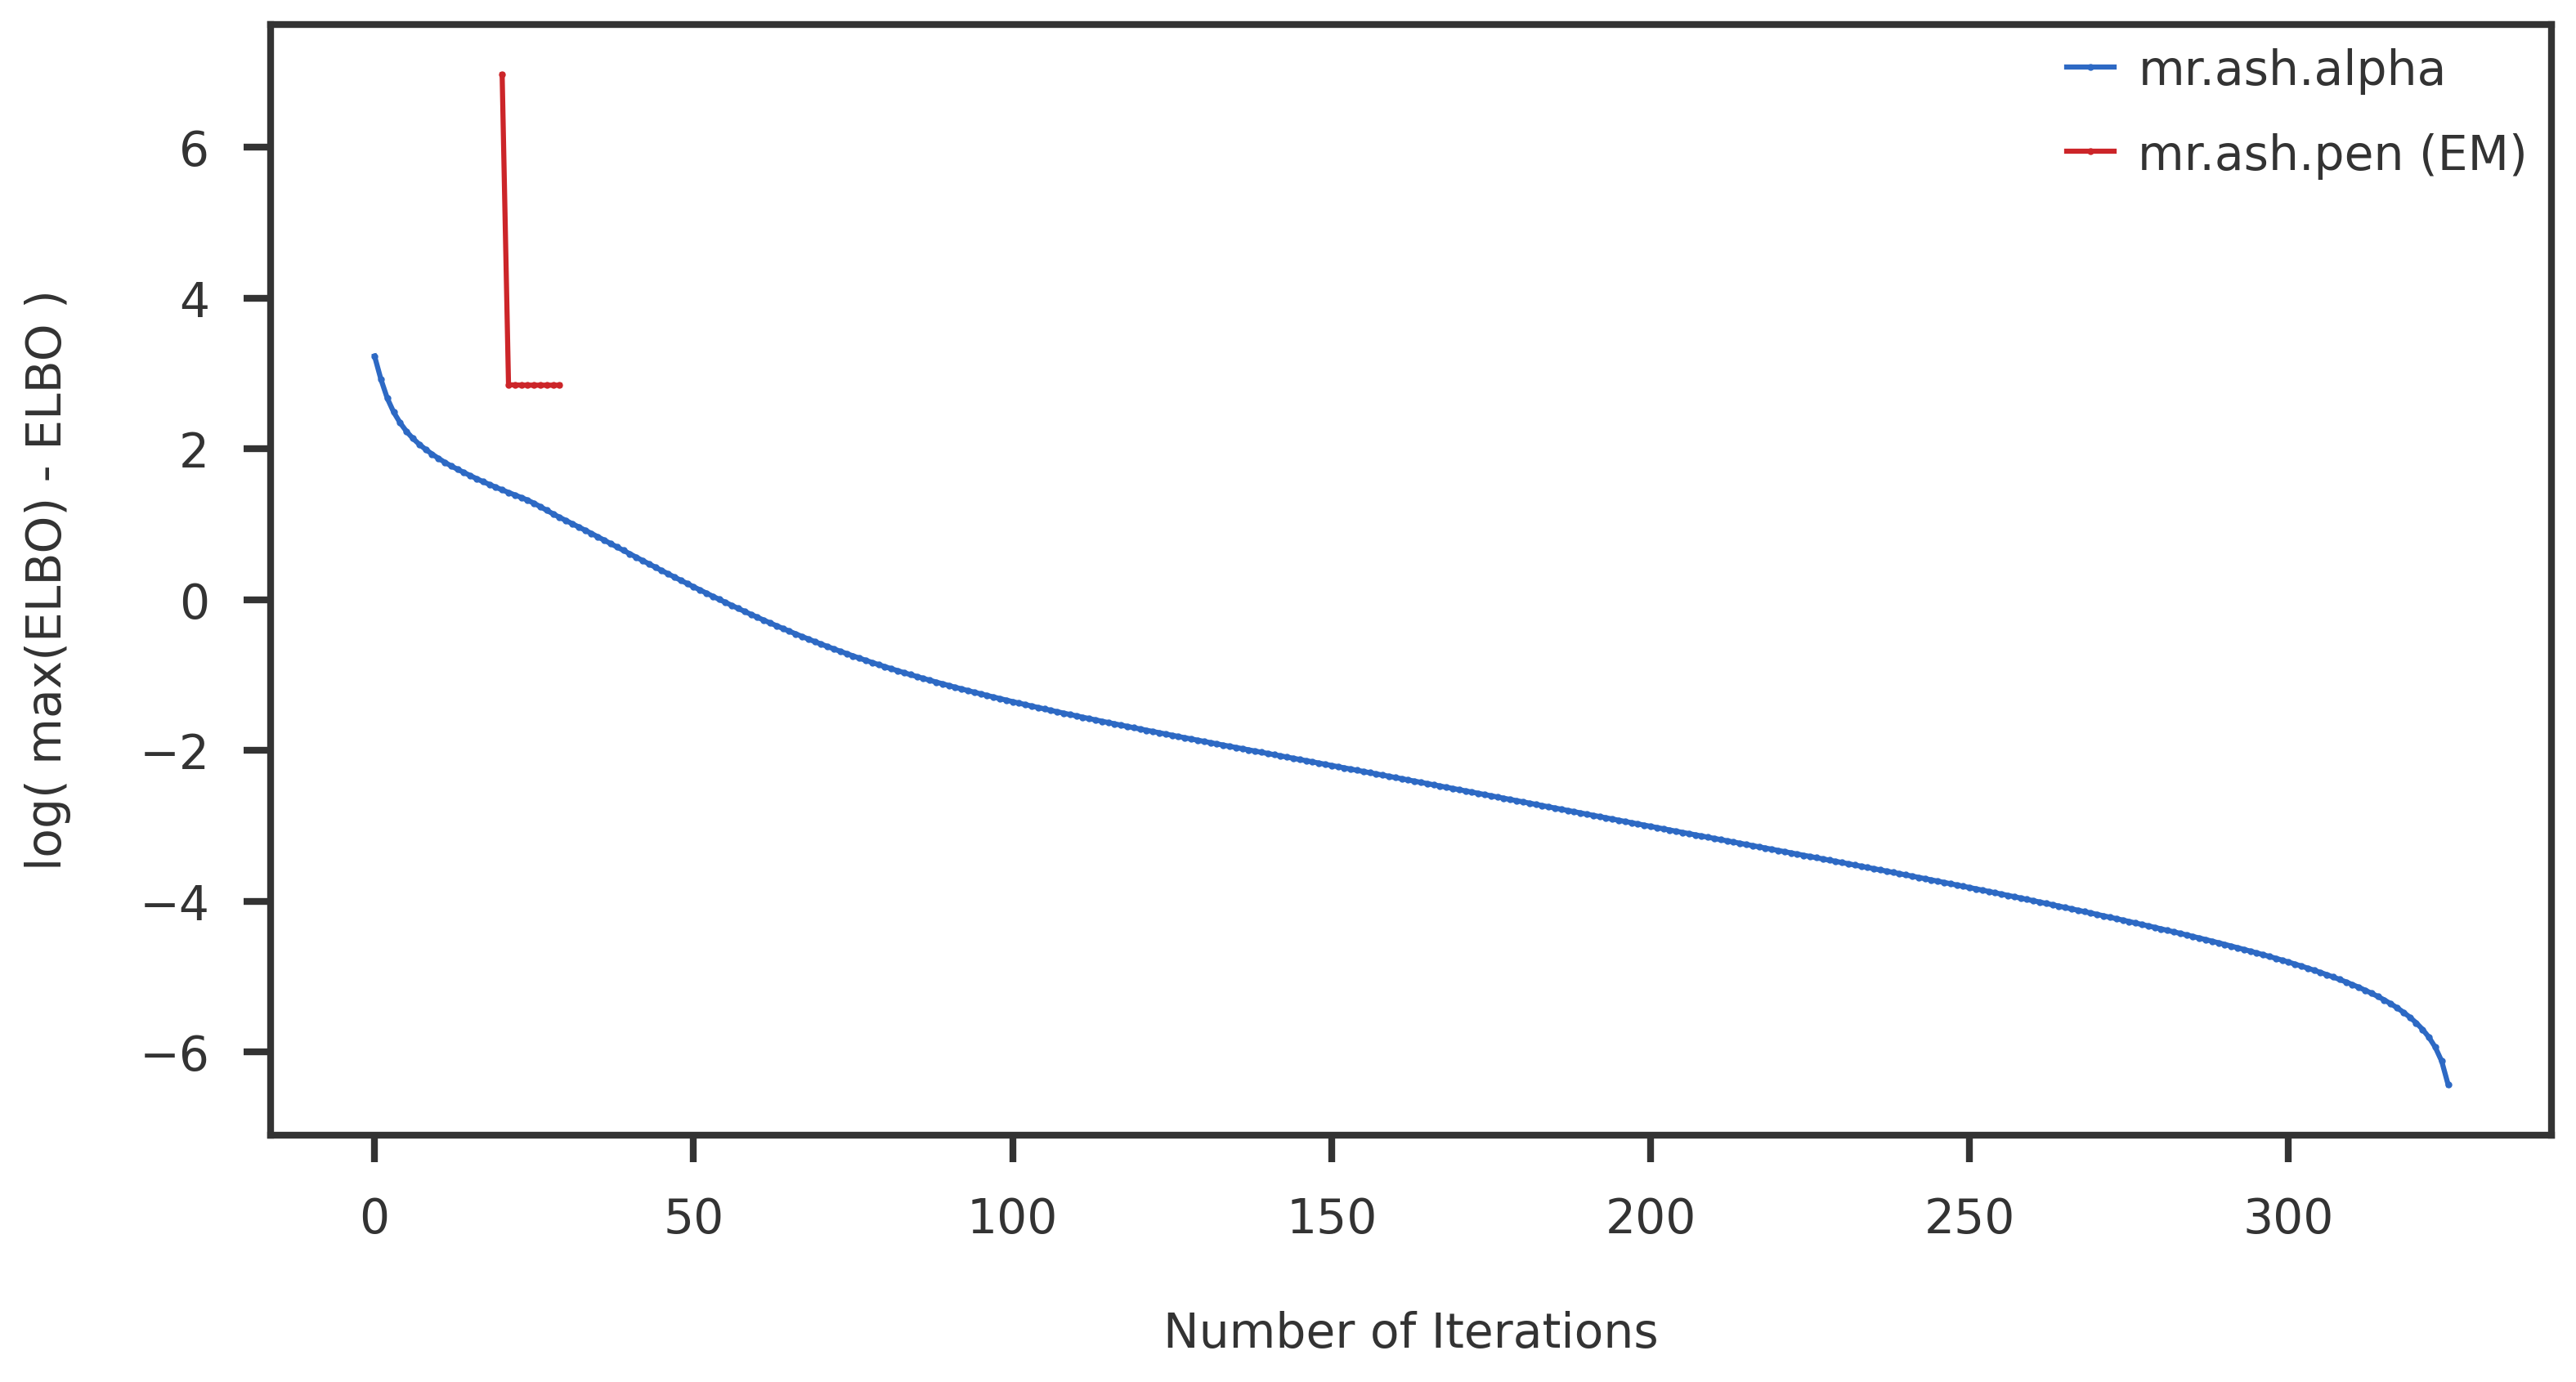

In [20]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')

kinit   = [0, 20]
objs    = [mrash_r.obj_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

In [109]:
import numpy as np
import collections
from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference import elbo as elbo_py
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled


RES_FIELDS = ['theta', 'coef', 'prior', 'residual_var', 'intercept', 'elbo_path', 'outer_elbo_path', 'obj_path', 'niter']
class ResInfo(collections.namedtuple('_ResInfo', RES_FIELDS)):
    __slots__ = ()
    
    
def b_to_theta(X, y, b):
    n, p = X.shape
    r  = y - np.mean(y) - np.dot(X, b)
    rj = r.reshape(n, 1) + X * b.reshape(1, p)
    dj = np.sum(np.square(X), axis = 0)
    theta = np.einsum('ij,ij->j', X, rj) / dj
    return theta

def update_sigma2(phijk, mujk, btilde):
    ### Update s2
    bbar   = np.sum(phijk * mujk, axis = 1)
    a1     = np.sum(dj * bbar * btilde)
    varobj = np.dot(r, r) - np.dot(np.square(b), dj) + a1
    s2     = (varobj + p * (1 - w[0]) * s2old) / (n + p * (1 - w[0]))


def ebfit(X, y, sk, wk, binit = None, s2init = 1,
          maxiter = 1000, qb_maxiter = 100,
          calculate_elbo = True,
          epstol = 1e-8):
    n, p = X.shape
    k    = sk.shape[0]
    intercept = np.mean(y)
    y    = y - intercept
    dj   = np.sum(np.square(X), axis = 0)

    niter = 0 
    w  = wk
    s2 = s2init
    b  = binit
    elbo_path = list()
    obj_path  = list()
    elbo  = np.inf
    outer_elbo_path = list()

    for it in range(maxiter):

        ### Remember old parameters
        bold  = b.copy() if b is not None else b
        wold  = w.copy()
        s2old = s2
        elboold = elbo


        ### Update b
        plr = PLR(method = 'L-BFGS-B', optimize_w = False, optimize_s = False, is_prior_scaled = True,
                  debug = False, display_progress = False, calculate_elbo = calculate_elbo, maxiter = qb_maxiter,
                  call_from_em = True)
        plr.fit(X, y, sk, binit = bold, winit = wold, s2init = s2old) 
        b = plr.coef
        theta = plr.theta
        r = y - np.dot(X, b)
        elbo_path += plr.elbo_path
        obj_path  += plr.obj_path

        ### calculate ELBO before updating w and s2
        btilde = b + np.dot(X.T, r) / dj
        nmash = NormalMeansASHScaled(btilde, np.sqrt(s2), w, sk, d = dj, debug = False)
        phijk, mujk, varjk = nmash.posterior()
        #elbo   = elbo_py.scalemix(X, y, sk, b, w, s2, 
        #                          dj = dj, phijk = phijk, mujk = mujk, varjk = varjk, eps = 1e-8)
        #outer_elbo_path.append(elbo)

        ### Update w
        w = np.sum(phijk, axis = 0) / p
        
        ### Update s2
        bbar   = np.sum(phijk * mujk, axis = 1)
        a1     = np.sum(dj * bbar * btilde)
        varobj = np.dot(r, r) - np.dot(np.square(b), dj) + a1
        s2     = (varobj + p * (1 - w[0]) * s2old) / (n + p * (1 - w[0]))
        
        ### New b / theta
        b = bbar.copy()
        elbo = elbo_py.scalemix(X, y, sk, b, w, s2, 
                                dj = dj, phijk = phijk, mujk = mujk, varjk = varjk, eps = 1e-8)
        outer_elbo_path.append(elbo)

        ### Convergence
        ### No elbo in history before one iteration so cannot compare
        print(elbo, elboold)
        if (it > 0) and (elboold - elbo < epstol):
            break
            
    print (f"mr.ash.pen (EM) terminated at iteration {it + 1}.")

    res = ResInfo(theta = theta,
                  coef = b,
                  prior = w,
                  residual_var = s2,
                  intercept = intercept,
                  elbo_path = elbo_path,
                  outer_elbo_path = outer_elbo_path,
                  obj_path = obj_path,
                  niter = len(elbo_path))

    return res

In [56]:
def nmash_posterior(y, s2, wk, sk, dj):
    print(f"Calculating posterior for NM model.")
    n   = y.shape[0]
    k   = sk.shape[0]
    sk2 = np.square(sk).reshape(1, k)
    y2  = np.square(y).reshape(n, 1)
    dj  = dj.reshape(n, 1)
    nonzero_widx = np.where(wk != 0)[0]

    v2jk  = sk2 + (1 / dj)
    varjk = (s2 * sk2) / (v2jk * dj)
    mujk  = y.reshape(n, 1) * sk2 / v2jk

    phijk  = np.zeros((n, k))
    logLjk = nmash_logLjk()
    phijk[:, nonzero_widx] = logLjk[:, nonzero_widx] + np.log(wk[nonzero_widx])
    zjk    = logLjk[:, nonzero_widx] + np.log(wk[self._nonzero_widx])
    zjkmax = np.max(zjk, axis = 1)
    phijk[:, self._nonzero_widx] = np.exp(zjk - zjkmax.reshape(-1, 1))
    phijk /= np.sum(phijk, axis = 1).reshape(self._n, 1)
    #phijk[:, self._nonzero_widx] = np.exp(zjk - self.log_sum_wkLjk(logLjk).reshape(-1,1))
    return phijk, mujk, varjk


r  = y - np.dot(X, plr_eb.coef)
dj = np.sum(np.square(X), axis = 0)
btilde = plr_eb.coef + np.dot(X.T, r) / dj
nmash = NormalMeansASHScaled(btilde, np.sqrt(plr_eb.residual_var), plr_eb.prior, sk, d = dj, debug = False)
phijk, mujk, varjk = nmash.posterior()

In [61]:
np.sum(phijk, axis = 0)

array([0.00000000e+00, 1.97633384e+03, 8.18811758e-13, 1.85780696e-30,
       6.06008041e-44, 4.60023725e-49, 7.82864342e-47, 9.99498635e-41,
       2.42546644e-33, 4.97288255e-26, 1.90002166e-19, 6.96819737e-14,
       2.11041469e-09, 6.11955441e-06, 2.24892935e-03, 1.41556809e-01,
       1.98714156e+00, 7.66832475e+00, 9.53979707e+00, 4.32708547e+00])

In [62]:
wk

array([0.        , 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158])